2025-08-20 09:21:16.808510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755681676.997964      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755681677.051022      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Data split done.
Train images: 9429
Test images: 2361
Found 9429 images belonging to 9 classes.
Found 2361 images belonging to 9 classes.
Classes: 9, steps_per_epoch: 295, val_steps: 74


I0000 00:00:1755681849.049993      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755681849.050671      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1755681868.451061      95 service.cc:148] XLA service 0x7f52d0114c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755681868.451841      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755681868.451852      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755681870.369569      95 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755681879.989327      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 - 152s - 514ms/step - accuracy: 0.5276 - loss: 1.4076 - val_accuracy: 0.6887 - val_loss: 0.9924
Epoch 2/15
295/295 - 104s - 351ms/step - accuracy: 0.7285 - loss: 0.8116 - val_accuracy: 0.7933 - val_loss: 0.6502
Epoch 3/15
295/295 - 101s - 344ms/step - accuracy: 0.8000 - loss: 0.6156 - val_accuracy: 0.8441 - val_loss: 0.5088
Epoch 4/15
295/295 - 101s - 344ms/step - accuracy: 0.8382 - loss: 0.5167 - val_accuracy: 0.8708 - val_loss: 0.4227
Epoch 5/15
295/295 - 99s - 335ms/step - accuracy: 0.8674 - loss: 0.4228 - val_accuracy: 0.8890 - val_loss: 0.3621
Epoch 6/15
295/295 - 101s - 343ms/step - accuracy: 0.8932 - loss: 0.3672 - val_accuracy: 0.8950 - val_loss: 0.3233
Epoch 7/15
295/295 - 100s - 341ms/step - accuracy: 0.9087 - loss: 0.3213 - val_accuracy: 0.9127 - val_loss: 0.2867
Epoch 8/15
295/295 - 102s - 345ms/step - accuracy: 0.9177 - loss: 0.2794 - val_accuracy: 0.9229 - val_loss: 0.2545
Epoch 9/15
295/295 - 99s - 336ms/step - accuracy: 0.9298 - loss: 0.2499 - val_accuracy: 0.92

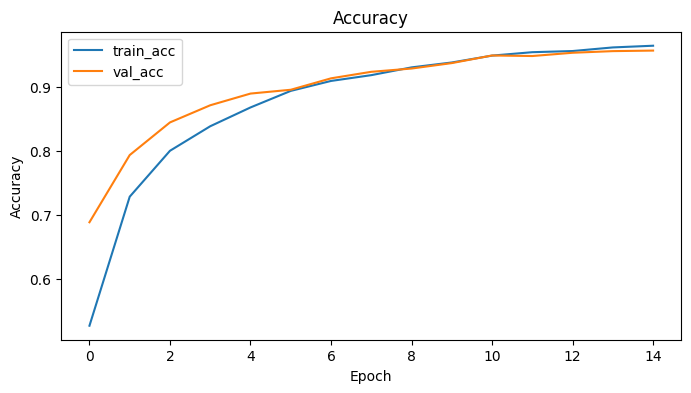

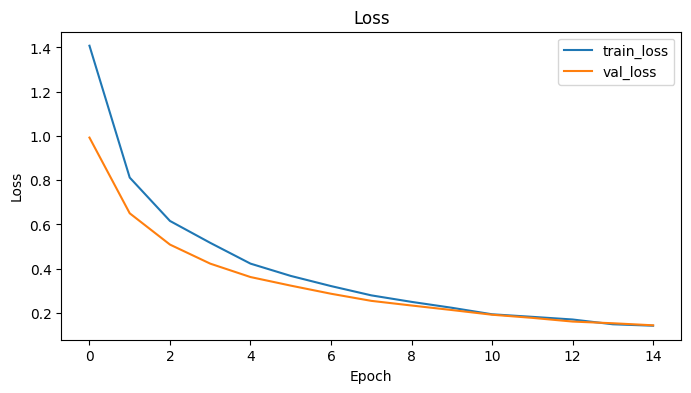

74/74 ━━━━━━━━━━━━━━━━━━━━ 33s 349ms/step


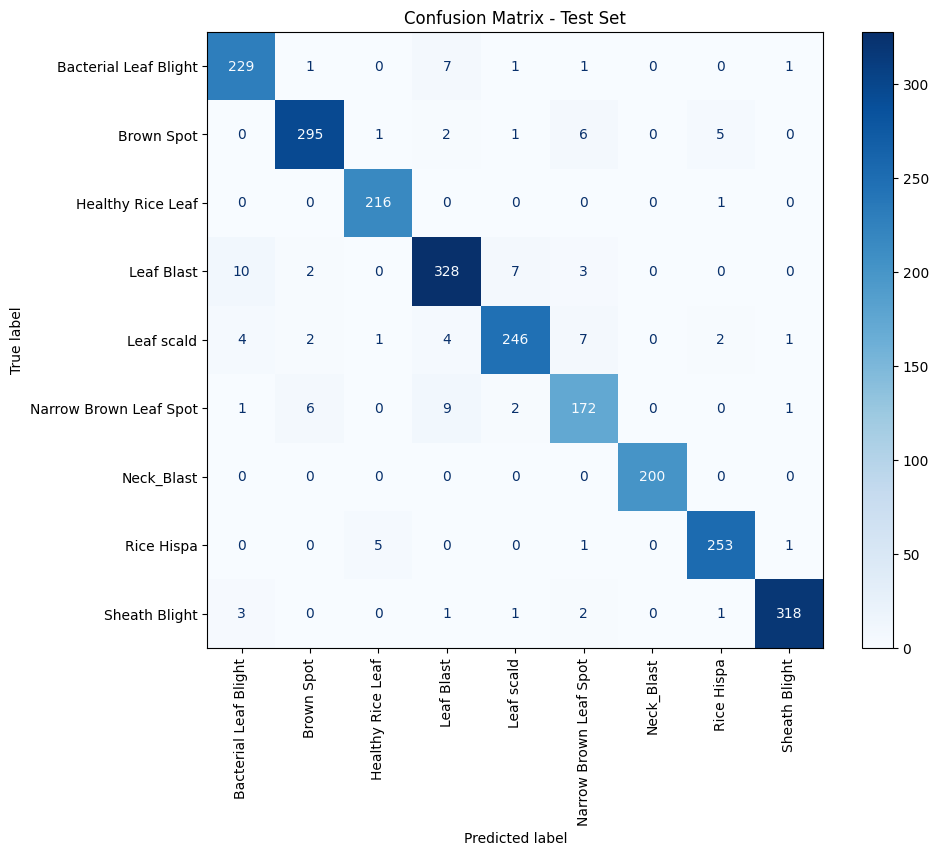


Overall Test Metrics:
Accuracy  : 0.9560
Precision : 0.9561
Recall    : 0.9560
F1-score  : 0.9559
Saved model -> efficientnetb0_model.h5


In [1]:
# fast_train_script_15epochs.py
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------
# Config / reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

SOURCE_DIR = '/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG'
TRAIN_DIR = '/kaggle/working/train'
TEST_DIR = '/kaggle/working/test'
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# -------------------------
# Data split (20% test)
# -------------------------
for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(class_path):
        continue
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=SEED, shuffle=True)

    train_cdir = os.path.join(TRAIN_DIR, class_name)
    test_cdir = os.path.join(TEST_DIR, class_name)
    os.makedirs(train_cdir, exist_ok=True)
    os.makedirs(test_cdir, exist_ok=True)

    for f in train_files:
        src = os.path.join(class_path, f)
        dst = os.path.join(train_cdir, f)
        if not os.path.exists(dst):
            shutil.copy(src, dst)
    for f in test_files:
        src = os.path.join(class_path, f)
        dst = os.path.join(test_cdir, f)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

print("Data split done.")
print("Train images:", sum(len(os.listdir(os.path.join(TRAIN_DIR, d))) for d in os.listdir(TRAIN_DIR)))
print("Test images:", sum(len(os.listdir(os.path.join(TEST_DIR, d))) for d in os.listdir(TEST_DIR)))

# -------------------------
# Hyperparameters
# -------------------------
BATCH_SIZE = 32
IMG_SIZE = (224, 224)   # EfficientNetB0 default
INITIAL_LR = 1e-4
EPOCHS = 15             # fixed to 15

# -------------------------
# Generators (lighter augmentation)
# -------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True
)

eval_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED
)

test_ds = eval_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

NUM_CLASSES = len(train_ds.class_indices)
STEPS_PER_EPOCH = len(train_ds)
VALIDATION_STEPS = len(test_ds)
print(f"Classes: {NUM_CLASSES}, steps_per_epoch: {STEPS_PER_EPOCH}, val_steps: {VALIDATION_STEPS}")

# -------------------------
# Model
# -------------------------
base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False  # freeze base

model = Sequential([
    base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax')
])

# -------------------------
# Compile & fit
# -------------------------
opt = Adam(learning_rate=INITIAL_LR)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stop],
    verbose=2
)

# -------------------------
# Plots: accuracy / loss
# -------------------------
plt.figure(figsize=(8,4))
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -------------------------
# Confusion matrix & overall metrics
# -------------------------
test_ds.reset()
pred_probs = model.predict(test_ds, steps=VALIDATION_STEPS, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = test_ds.classes
idx_to_class = {v:k for k,v in test_ds.class_indices.items()}
labels_ordered = [idx_to_class[i] for i in range(NUM_CLASSES)]

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_ordered)
plt.figure(figsize=(10,8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, ax=plt.gca())
plt.title('Confusion Matrix - Test Set')
plt.show()

# Overall metrics
acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels, average='weighted')
rec = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("\nOverall Test Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

# -------------------------
# Save model
# -------------------------
model.save('efficientnetb0_model.h5')
print("Saved model -> efficientnetb0_model.h5")


In [2]:
# -------------------------
# Evaluation (Train & Test Accuracy)
# -------------------------
print("\n--- Final Evaluation ---")
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")



--- Final Evaluation ---
Train Accuracy: 0.9933
Test Accuracy:  0.9560
